<a href="https://colab.research.google.com/github/Joshuajee/AI-ML-PROJECTS/blob/master/Topic%20Modelling%20on%20Financial%20Posts%20from%20Redit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyLDAvis
!pip install bertopic
!pip install flair
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


** **
## Step 1: Loading the Data
** **
The data was collected manually from twenty two financial subreddit and saved in a csv format to my github repo.

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import gensim
import nltk
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# BERTopic model
from bertopic import BERTopic
# Dimension reduction
from umap import UMAP
# Clustering
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
# Count vectorization
from sklearn.feature_extraction.text import CountVectorizer
# Sentence transformer
from sentence_transformers import SentenceTransformer
# Flair
from transformers.pipelines import pipeline
from flair.embeddings import TransformerDocumentEmbeddings, WordEmbeddings, DocumentPoolEmbeddings, StackedEmbeddings


In [3]:
def get_redit_data_from_github():
  file_path = "https://raw.githubusercontent.com/Joshuajee/AI-ML-PROJECTS/master/data/reddit/reddit_financial_data.csv"
  reponse = requests.get(file_path)
  if reponse.status_code == 200:
    with open("reddit_financial_data.csv", "wb") as f:
      f.write(reponse.content)
    return pd.read_csv("reddit_financial_data.csv", sep=",")
  else:
    raise Exception("Error downloading", reponse.status_code)


In [4]:
reddit_data = get_redit_data_from_github()
reddit_data

,Unnamed: 0,id,subreddit,title,text,url,score,num_comments,created_utc
0,0,1jd5ybv,finance,"Moronic Monday - March 17, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1jd5...,3,20,1.742191e+09
1,1,1jfd4r2,finance,"$1.4bn is a lot to fall through the cracks, ev...",Interesting post on Tesla's accounting (from t...,https://www.ft.com/content/62df8d8d-31f2-445e-...,1206,89,1.742433e+09
2,2,1j7s07n,finance,"Moronic Monday - March 10, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j7s...,5,21,1.741586e+09
3,3,1j4i8hv,finance,"Goldman, JPMorgan Among Banks Offering More Ru...",The Trump administration isn’t the only one lo...,https://www.bloomberg.com/news/articles/2025-0...,118,10,1.741220e+09
4,4,1j2c1rd,finance,"Moronic Monday - March 03, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j2c...,3,28,1.740982e+09
...,...,...,...,...,...,...,...,...,...
12870,12870,1ipd9px,dividends,"1,000,000.00 in a schwab money market fund mak...",Super interested in dividend stocks but am a c...,https://www.reddit.com/r/dividends/comments/1i...,161,93,1.739547e+09
12871,12871,1iq6xxy,dividends,New Investor interested in Dividends.,I'm new to investing and just had my first kid...,https://www.reddit.com/r/dividends/comments/1i...,0,10,1.739642e+09
12872,12872,1iq6e30,dividends,Survey for Research-Paper,"Hi \nI’m conducting a survey on the speed, ac...",https://www.reddit.com/r/dividends/comments/1i...,0,1,1.739640e+09
12873,12873,1ipz087,dividends,PBR-A vs. EC,The yields here look very interesting. What is...,https://www.reddit.com/r/dividends/comments/1i...,3,5,1.739617e+09


** **
## Step 2: Data Cleaning
** **

The reddit post data contains multiple columns, but since this is an NLP task only the text and title columns are useful for our Topic modeling task the other columns will be ignored.

1. Join the title and the text columns
2. Remove punctuations and special characters.




In [5]:
# Join the title and text columns in a new content column
reddit_data['content'] = reddit_data['title'] + ' ' + reddit_data['text']
reddit_data

,Unnamed: 0,id,subreddit,title,text,url,score,num_comments,created_utc,content
0,0,1jd5ybv,finance,"Moronic Monday - March 17, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1jd5...,3,20,1.742191e+09,"Moronic Monday - March 17, 2025 - Your Weekly ..."
1,1,1jfd4r2,finance,"$1.4bn is a lot to fall through the cracks, ev...",Interesting post on Tesla's accounting (from t...,https://www.ft.com/content/62df8d8d-31f2-445e-...,1206,89,1.742433e+09,"$1.4bn is a lot to fall through the cracks, ev..."
2,2,1j7s07n,finance,"Moronic Monday - March 10, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j7s...,5,21,1.741586e+09,"Moronic Monday - March 10, 2025 - Your Weekly ..."
3,3,1j4i8hv,finance,"Goldman, JPMorgan Among Banks Offering More Ru...",The Trump administration isn’t the only one lo...,https://www.bloomberg.com/news/articles/2025-0...,118,10,1.741220e+09,"Goldman, JPMorgan Among Banks Offering More Ru..."
4,4,1j2c1rd,finance,"Moronic Monday - March 03, 2025 - Your Weekly ...",This is your safe place for questions on finan...,https://www.reddit.com/r/finance/comments/1j2c...,3,28,1.740982e+09,"Moronic Monday - March 03, 2025 - Your Weekly ..."
...,...,...,...,...,...,...,...,...,...,...
12870,12870,1ipd9px,dividends,"1,000,000.00 in a schwab money market fund mak...",Super interested in dividend stocks but am a c...,https://www.reddit.com/r/dividends/comments/1i...,161,93,1.739547e+09,"1,000,000.00 in a schwab money market fund mak..."
12871,12871,1iq6xxy,dividends,New Investor interested in Dividends.,I'm new to investing and just had my first kid...,https://www.reddit.com/r/dividends/comments/1i...,0,10,1.739642e+09,New Investor interested in Dividends. I'm new ...
12872,12872,1iq6e30,dividends,Survey for Research-Paper,"Hi \nI’m conducting a survey on the speed, ac...",https://www.reddit.com/r/dividends/comments/1i...,0,1,1.739640e+09,Survey for Research-Paper Hi \nI’m conducting ...
12873,12873,1ipz087,dividends,PBR-A vs. EC,The yields here look very interesting. What is...,https://www.reddit.com/r/dividends/comments/1i...,3,5,1.739617e+09,PBR-A vs. EC The yields here look very interes...


In [6]:
# Create a new DataFrame containing only the content column
content_df = reddit_data[['content']].copy()
content_df

,content
0,"Moronic Monday - March 17, 2025 - Your Weekly ..."
1,"$1.4bn is a lot to fall through the cracks, ev..."
2,"Moronic Monday - March 10, 2025 - Your Weekly ..."
3,"Goldman, JPMorgan Among Banks Offering More Ru..."
4,"Moronic Monday - March 03, 2025 - Your Weekly ..."
...,...
12870,"1,000,000.00 in a schwab money market fund mak..."
12871,New Investor interested in Dividends. I'm new ...
12872,Survey for Research-Paper Hi \nI’m conducting ...
12873,PBR-A vs. EC The yields here look very interes...


In [7]:
def preprocess(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
    text = text.lower()  # Lowercase text
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [8]:
# Cleaning the data gotton from reddit as it contains relevant characters
content_df['cleaned_content'] = content_df['content'].apply(preprocess)
content_df

,content,cleaned_content
0,"Moronic Monday - March 17, 2025 - Your Weekly ...",moronic monday march 17 2025 your weekly quest...
1,"$1.4bn is a lot to fall through the cracks, ev...",14bn is a lot to fall through the cracks even ...
2,"Moronic Monday - March 10, 2025 - Your Weekly ...",moronic monday march 10 2025 your weekly quest...
3,"Goldman, JPMorgan Among Banks Offering More Ru...",goldman jpmorgan among banks offering more rus...
4,"Moronic Monday - March 03, 2025 - Your Weekly ...",moronic monday march 03 2025 your weekly quest...
...,...,...
12870,"1,000,000.00 in a schwab money market fund mak...",100000000 in a schwab money market fund making...
12871,New Investor interested in Dividends. I'm new ...,new investor interested in dividends im new to...
12872,Survey for Research-Paper Hi \nI’m conducting ...,survey for researchpaper hi im conducting a su...
12873,PBR-A vs. EC The yields here look very interes...,pbra vs ec the yields here look very interesti...


In [9]:
# Removing stop words
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nltk.download('punkt_tab')
nltk.download('omw-1.4')
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

# Removing stop words from wordlist columns
content_df['cleaned_content_no_sw'] = content_df['cleaned_content'].apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))
# Lemmatization
content_df['cleaned_content_lm_no_sw'] = content_df['cleaned_content_no_sw'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stop_words]))
content_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,cleaned_content,cleaned_content_no_sw,cleaned_content_lm_no_sw
0,"Moronic Monday - March 17, 2025 - Your Weekly ...",moronic monday march 17 2025 your weekly quest...,moronic monday march 17 2025 weekly questions ...,moronic monday march 17 2025 weekly question t...
1,"$1.4bn is a lot to fall through the cracks, ev...",14bn is a lot to fall through the cracks even ...,14bn lot fall cracks even tesla interesting po...,14bn lot fall crack even tesla interesting pos...
2,"Moronic Monday - March 10, 2025 - Your Weekly ...",moronic monday march 10 2025 your weekly quest...,moronic monday march 10 2025 weekly questions ...,moronic monday march 10 2025 weekly question t...
3,"Goldman, JPMorgan Among Banks Offering More Ru...",goldman jpmorgan among banks offering more rus...,goldman jpmorgan among banks offering russiali...,goldman jpmorgan among bank offering russialin...
4,"Moronic Monday - March 03, 2025 - Your Weekly ...",moronic monday march 03 2025 your weekly quest...,moronic monday march 03 2025 weekly questions ...,moronic monday march 03 2025 weekly question t...
...,...,...,...,...
12870,"1,000,000.00 in a schwab money market fund mak...",100000000 in a schwab money market fund making...,100000000 schwab money market fund making 42 s...,100000000 schwab money market fund making 42 s...
12871,New Investor interested in Dividends. I'm new ...,new investor interested in dividends im new to...,new investor interested dividends im new inves...,new investor interested dividend im new invest...
12872,Survey for Research-Paper Hi \nI’m conducting ...,survey for researchpaper hi im conducting a su...,survey researchpaper hi im conducting survey s...,survey researchpaper hi im conducting survey s...
12873,PBR-A vs. EC The yields here look very interes...,pbra vs ec the yields here look very interesti...,pbra vs ec yields look interesting thought eit...,pbra v ec yield look interesting thought eithe...


** **
## Step 3: Exploratory Analysis <a class="anchor\" id="eda"></a>
** **
To better understand our data, I will make and histogram about to show the distrubution of words per posts.

To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.



In [10]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(content_df['cleaned_content'])
print(f"Total unique words raw               : {len(vectorizer.get_feature_names_out())}")
X = vectorizer.fit_transform(content_df['cleaned_content_no_sw'])
print(f"Total unique words without stop words: {len(vectorizer.get_feature_names_out())}")
X = vectorizer.fit_transform(content_df['cleaned_content_lm_no_sw'])
print(f"Total unique words with lemmatization: {len(vectorizer.get_feature_names_out())}")

Total unique words raw               : 48181
Total unique words without stop words: 48050
Total unique words with lemmatization: 44595


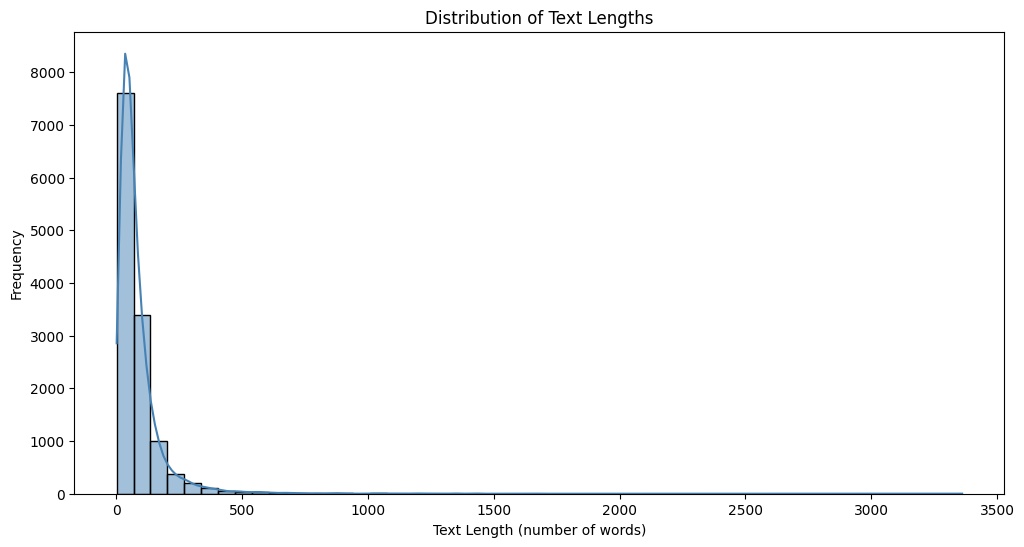

In [11]:
text_lengths = [len(x) for x in content_df['cleaned_content_lm_no_sw'].apply(lambda x: [w for w in x.split() if w not in stop_words])]

# Set up the figure size
plt.figure(figsize=(12, 6))

# Plot the histogram using seaborn with a KDE overlay.
sns.histplot(text_lengths, bins=50, kde=True, color="steelblue")

# Add plot labels and title
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length (number of words)")
plt.ylabel("Frequency")

# Show the plot
plt.show()

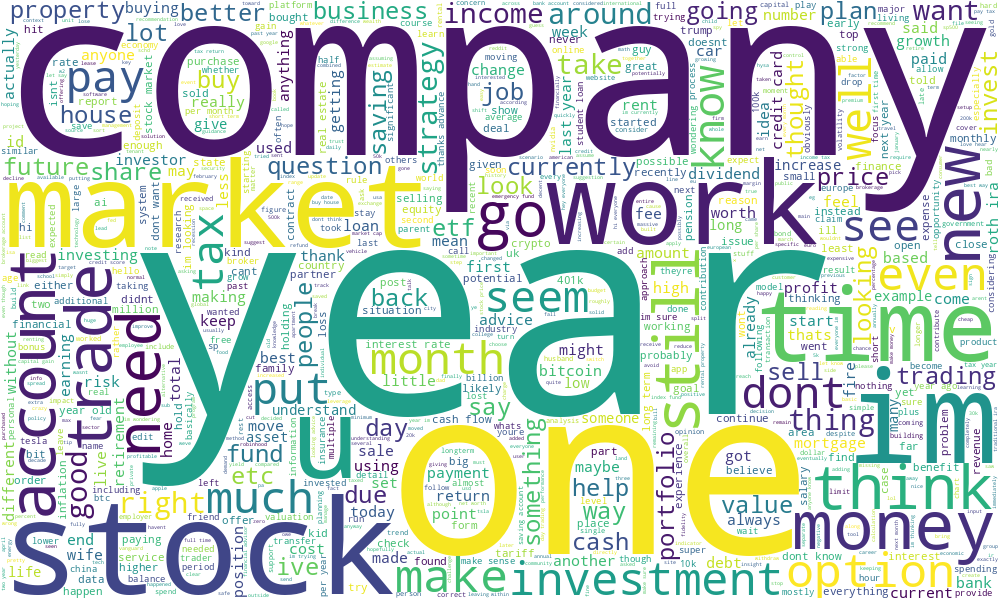

In [12]:
# Import the wordcloud library
from wordcloud import WordCloud

data_words = content_df['cleaned_content_lm_no_sw'].explode().to_list()

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, width=1000, height=600, contour_color='steelblue')

# Generate a big chunck of text
big_chunck_text = " ".join(data_words)

# Generate a word cloud
wordcloud.generate(big_chunck_text)

# Visualize the word cloud
wordcloud.to_image()

** **
## Step 4: Building the Models <a class="anchor\" id="models"></a>
** **

For this tasks, I will be using LDA and Bertopic


In [13]:
# Hyperparameters
max_df = 0.9
min_df = 4
max_features = 10000

n_components = 5
n_top_words = 20


** **
### Latent Dirichlet Allocation (LDA) <a class="anchor\" id="lda"></a>
** **


In [14]:
tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words="english")

tf = tf_vectorizer.fit_transform(content_df['cleaned_content_lm_no_sw'])

lda = LatentDirichletAllocation(n_components=n_components, learning_method="online", learning_offset=50.0, random_state=100)

lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=5, random_state=100)

** **
###  BERTopic model tranining <a class="anchor\" id="train_model"></a>
** **

In [ ]:
# Initiate UMAP
kmeans_model = KMeans(n_clusters=n_components)

umap_model = UMAP(n_neighbors=15, n_components=n_components, min_dist=0.0, metric='cosine', random_state=100)

model = SentenceTransformer('all-MiniLM-L6-v2')


topic_model = BERTopic(
    embedding_model=model,
    umap_model=umap_model,
    language="english",
    calculate_probabilities=True,
    hdbscan_model=kmeans_model,
    n_gram_range=(1, 3)
)

topics, probs = topic_model.fit_transform(content_df['cleaned_content_lm_no_sw'])

In [ ]:
topics[:20]

In [ ]:
probs

In [ ]:
# Get the list of topics
topic_model.get_topic_info()

In [ ]:
topic_model.visualize_topics()

** **
## Step 5: Results and Visualization <a class="anchor\" id="results"></a>
** **


In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

### BERTopic

In [ ]:
topic_model.visualize_barchart(top_n_topics=n_components, n_words=10, autoscale=True)

In [ ]:
topic_model.visualize_hierarchy()